In [ ]:
import numpy as np
import h5py
import xarray as xr
import pyproj
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean as cmo
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy
import cartopy.crs as ccrs
import string

import sys
sys.path.append('../')

from plotfunctions import add_lonlat

np.seterr(all='ignore')
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2

In [ ]:
proj = ccrs.SouthPolarStereo(true_scale_latitude=-78,central_longitude=-20)#260-360)
axex = [245.8,251,-75.2,-74.4]
axex2 = [295,300,-75.5,-75]

cmap1 = mpl.colors.ListedColormap(plt.get_cmap('cmo.deep_r')(np.linspace(0,.4,255)))
cmap2 = 'cmo.rain'
cmap3 = mpl.colors.ListedColormap(plt.get_cmap('cmo.gray')(np.linspace(.2,.6,255)))

x0,x1,y0,y1 = 3000,4500,4000,7000

In [ ]:
vmax = 100
vmin = -10
linthresh=1
linscale=.2

vmax = 100
vmin = -10
linthresh = .3
linscale = .25


fracpos = (np.log10(vmax/linthresh)+linscale)/(np.log10(vmax/linthresh)+np.log10(-(vmin/linthresh))+2*linscale)
#print(fracpos)
nneg = np.int_((1-fracpos)*256)

colors1 = plt.get_cmap('cmo.ice_r')(np.linspace(0,.9,nneg))
colors2 = plt.cm.inferno(np.linspace(0.1, 1, 256-nneg))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors)


In [58]:
def makebackground(ax,axx):
    cmap = plt.get_cmap('ocean')
    ds = xr.open_dataset('../../../data/BedMachineAntarctica_2020-07-15_v02.nc')
    ds = ds.isel(x=slice(x0,x1),y=slice(y0,y1))
    mask = xr.where(ds.mask==1,2,ds.mask)
    ds = add_lonlat(ds)
    
    ax.set_facecolor(".7")
    
    im1 = ax.pcolormesh(ds.lon,ds.lat,np.where(mask==0,ds.bed,np.nan),cmap=cmap1,shading='nearest',transform=ccrs.PlateCarree(),vmin=-1500,vmax=0)
    im2 = ax.pcolormesh(ds.lon,ds.lat,np.where(mask==2,ds.bed,np.nan),cmap=cmap3,shading='nearest',transform=ccrs.PlateCarree(),vmin=-2000,vmax=0)

    ax.annotate('Ice shelf\nfront',(.4,.8),xytext=(.28,.78),va='bottom',ha='right',arrowprops=dict(arrowstyle="->"),xycoords='axes fraction')
    ax.annotate('Crevasse',(.6,.8),xytext=(.6,.7),va='top',ha='left',arrowprops=dict(arrowstyle="->"),xycoords='axes fraction')

    
    ax.set_extent(axx,crs=ccrs.PlateCarree())

In [59]:
def plotmelt(ax,axx,lon,lat,melt,title=None):
    makebackground(ax,axx)
    ax.set_extent(axx,crs=ccrs.PlateCarree())
    im = ax.pcolormesh(lon,lat,melt,cmap=mymap,norm=mpl.colors.SymLogNorm(linthresh, vmin=vmin, vmax=vmax, linscale=linscale),shading='nearest',transform=ccrs.PlateCarree())

    ax.set_title(title,loc='left',fontsize=10)
        
    return im

In [60]:
#Get 3D model output
haus = xr.open_dataset('../../../data/hausmann/aq0519930101-19971231_5yrav5d2am_fwfisf.nc')
haus = haus.isel(time_counter=0)
haus.fwfisf[:] = -haus.fwfisf*365*24*3600/920
haus.fwfisf[:] = xr.where(haus.fwfisf==0,np.nan,haus.fwfisf)

In [61]:
#Read observations Adusumilli

fname = '../../../data/adusumilli/bb0448974g_3_1.h5'
hf = h5py.File(fname, 'r')
xa = np.array(hf['/x'])[:,0]
ya = np.array(hf['/y'])[:,0]
melta = np.array(hf['/w_b'])


data_vars = {'melt':(['y','x'],melta)}
coords = {'x': (['x'], xa),'y': (['y'], ya)}

dsa = xr.Dataset(data_vars=data_vars,coords=coords)
dsa = dsa.isel(x=slice(2000,5000),y=slice(4500,7000))
dsa = add_lonlat(dsa)

/nobackup/users/lambert/miniconda3/envs/layer/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/nobackup/users/lambert/miniconda3/envs/layer/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/nobackup/users/lambert/miniconda3/envs/layer/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell 

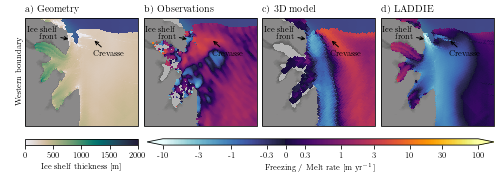

In [63]:
plt.style.use('style_paper')

mpl.rc('figure.subplot',left=.05,right=.98,top=.95,bottom=.25,wspace=.05,hspace=.05)

fig = plt.figure(figsize=(7,2.5))

#Geometry
ds = xr.open_dataset('../../../data/BedMachineAntarctica_2020-07-15_v02.nc')
ds = ds.isel(x=slice(x0,x1),y=slice(y0,y1))
ds = add_lonlat(ds)

ax = fig.add_subplot(141,projection=proj)
makebackground(ax,axex2)
ax.set_extent(axex2,crs=ccrs.PlateCarree())
ax.set_title('a) Geometry',loc='left',fontsize=10)
im2 = ax.pcolormesh(ds.lon,ds.lat,np.where(ds.mask==3,ds.thickness,np.nan),cmap=cmap2,shading='nearest',transform=ccrs.PlateCarree(),vmin=0,vmax=2000)
ax.text(-.08,.5,'Western boundary',rotation=90,va='center',transform=ax.transAxes)

#Obs

ax = fig.add_subplot(142,projection=proj)
makebackground(ax,axex2)
im = ax.pcolormesh(dsa.lon,dsa.lat,dsa.melt,shading='auto',cmap=mymap,norm=mpl.colors.SymLogNorm(linthresh, vmin=vmin, vmax=vmax, linscale=linscale),transform=ccrs.PlateCarree())
#ax.set_extent(axex2,crs=ccrs.PlateCarree())
ax.set_title('b) Observations',loc='left',fontsize=10)

#3D model


ax = fig.add_subplot(143,projection=proj)
makebackground(ax,axex2)

im = ax.pcolormesh(haus.nav_lon,haus.nav_lat,haus.fwfisf,shading='auto',cmap=mymap,norm=mpl.colors.SymLogNorm(linthresh, vmin=vmin, vmax=vmax, linscale=linscale),transform=ccrs.PlateCarree())

ax.set_title('c) 3D model',loc='left',fontsize=10)

#LADDIE at 500m
ds = xr.open_dataset(f'../../results/FRIS_1.0_linear_S134.8_T1-2.3_720.nc')

ax = fig.add_subplot(144,projection=proj)
im = plotmelt(ax,axex2,ds.lon,ds.lat,np.where(ds.tmask,ds.melt,np.nan),'d) LADDIE')

#Colorbars

ax = fig.add_subplot(111)
ax.set_visible(False)
cax = inset_axes(ax,width="24%",height="5%",loc='lower left',bbox_to_anchor=(0,-.08,1,1),bbox_transform=ax.transAxes,borderpad=0)
cb = plt.colorbar(im2,cax=cax,orientation='horizontal')
cb.set_label('Ice shelf thickness [m]')

cax = inset_axes(ax,width="74%",height="5%",loc='lower left',bbox_to_anchor=(.26,-.08,1,1),bbox_transform=ax.transAxes,borderpad=0)
ticks = [-10,-3,-1,-.3,0,.3,1,3,10,30,100]
cb = plt.colorbar(im,cax=cax,orientation='horizontal',extend='both')
cb.set_ticks(ticks)
cb.set_ticklabels(ticks)
cb.set_label('Freezing / Melt rate [m yr$^{-1}$]')

plt.savefig('../../figures/draftplot_FR_WB.png',dpi=450)